# RFP: Betting on the Bachelor

## Project Overview
You are invited to submit a proposal that answers the following question:

### Who will win season 29 of the Bachelor?

*All proposals must be submitted by **1/15/25 at 11:59 PM**.*

## Required Proposal Components

### 1. Data Description
In the code cell below, read in the data you plan on using to train and test your model. Call `info()` once you have read the data into a dataframe. Consider using some or all of the following sources:
- [Scrape Fandom Wikis](https://bachelor-nation.fandom.com/wiki/The_Bachelor) or [the official Bachelor website]('https://bachelornation.com/shows/the-bachelor/')
- [Ask ChatGPT to genereate it](https://chatgpt.com/)
- [Read in csv files like this](https://www.kaggle.com/datasets/brianbgonz/the-bachelor-contestants?select=contestants.csv)

*Note, a level 5 dataset contains at least 1000 rows of non-null data. A level 4 contains at least 500 rows of non-null data.*

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import bs4
import requests
import random
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from functools import reduce
from openai import OpenAI

In [2]:
df = pd.read_csv("bachelor-contestants.csv", encoding = "ISO-8859-1")

In [3]:
def Scrape(url : str, htmlIdentifier : str):
    URL = url
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
        
    data = soup.find_all(htmlIdentifier)
        
    return data

def getScrapedId(url : str, htmlIdentifier : str, idName : str):
    URL = url
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
        
    data = soup.find(htmlIdentifier, id=idName)
        
    return data

In [4]:
scrapedData = Scrape("https://bachelor-nation.fandom.com/wiki/The_Bachelor", "a")

In [5]:
links = {}
for data in scrapedData:
    title = data.get("title")
    
    if not type(title) == str: 
        continue
    
    if "The Bachelor (Season" in title:
        links[title] = f"https://bachelor-nation.fandom.com/" + data.get("href")
    
links

{'The Bachelor (Season 7)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_7)',
 'The Bachelor (Season 8)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_8)',
 'The Bachelor (Season 9)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_9)',
 'The Bachelor (Season 1)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_1)',
 'The Bachelor (Season 2)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_2)',
 'The Bachelor (Season 3)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_3)',
 'The Bachelor (Season 4)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_4)',
 'The Bachelor (Season 5)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_5)',
 'The Bachelor (Season 6)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_6)',
 'The Bachelor (Season 10)': 'https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_10)',
 'The Bachelor (Season 11)': 'https://

In [6]:
names : list = []
ages : list = []
hometowns : list = []
occupations : list = []
status : list = []

def GetBachelorSeason(link : str):
    URL = link
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    
    start_title = soup.find('span', id="Contestants")
    
    if not type(start_title) == bs4.element.Tag:
        return
    
    end_title = soup.find('span', id="Episodes")
    end_tr = end_title.find_previous("tr")
    elements_between = []
    
    current_tr = start_title.find_next('tr')
    tr_elements = []

    while current_tr and current_tr != end_tr:
        tr_elements.append(current_tr)
        current_tr = current_tr.find_next('tr')
        
    for contestantData in tr_elements:
        curTr = contestantData.find_next('td')
        if len(names) < 25 and not curTr.getText(strip=True) in names:
            names.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(ages) < 25:
            ages.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(hometowns) < 25:
            hometowns.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(occupations) < 25:
            occupations.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(status) < 25:
            numbers = 0
            if "Winner" in curTr.text:
                numbers = 6
            elif "Runner-up" in curTr.text:
                numbers = 6
            elif "Quit" in curTr.text:
                numbers = 0
            else:
                for char in curTr.text:
                    if char.isdigit():
                        numbers += float(char)
            status.append(numbers)
            
def ClearLists():
    names[:] = []
    ages[:] = []    
    hometowns[:] = []    
    occupations[:] = []    
    status[:] = []

In [7]:
def GetBachelorSeasonWiki(link : str, end : str = "Call-out_order", tag : str = "h2", start : str = "Contestants"):
    URL = link
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    
    start_title = soup.find(tag, id=start)
    
    if not type(start_title) == bs4.element.Tag:
        return
    
    end_title = soup.find(tag, id=end)
    end_tr = end_title.find_previous("tr")
    elements_between = []
    
    current_tr = start_title.find_next('tr')
    tr_elements = []

    while current_tr and current_tr != end_tr:
        tr_elements.append(current_tr)
        current_tr = current_tr.find_next('tr')
        
    for contestantData in tr_elements:
        curTr = contestantData.find_next('td')
        if len(names) < 25 and not curTr.getText(strip=True) in names:
            names.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(ages) < 25:
            ages.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(hometowns) < 25:
            hometowns.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(occupations) < 25:
            occupations.append(curTr.getText(strip=True))
        curTr = curTr.find_next('td')
        if len(status) < 25:
            numbers = 0
            if "Winner" in curTr.text:
                numbers = 6
            elif "Runner-up" in curTr.text:
                numbers = 6
            elif "Quit" in curTr.text:
                numbers = 0
            else:
                for char in curTr.text:
                    if char.isdigit():
                        numbers += float(char)
            status.append(numbers)



In [8]:
GetBachelorSeason("https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_3)")
season3_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}
s3_df = pd.DataFrame(season3_df)
s3_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Jennifer Schefft,25,"Mentor, Ohio",Publicist,6.0
1,Kirsten Buschbacher,25,"Mentor, Ohio",Publicist,6.0
2,Tina Panas,23,"Valrico, Florida",E-Commerce Merchant,6.0
3,Cristina Costa,22,"Oconomowoc, Wisconsin",Student,6.0
4,Anne-Michelle,30,"Montclair, New Jersey",Pharmaceutical sales consultant,5.0
5,Liz,25,"Burbank, California",Bartender/actress,4.0
6,Amber,23,"Chicago, Illinois",Event marketing director,4.0
7,Aubree,23,"Atlanta, Georgia",Account executive,3.0
8,Heather,26,"Las Vegas, Nevada",Hair stylist,3.0
9,Tina S.,22,"Waltham, Massachusetts",Student,3.0


In [9]:
ClearLists()
GetBachelorSeason("https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_4)")
season4_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}
s4_df = pd.DataFrame(season4_df)
s4_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Estella Gardinier,28,"Beverly Hills, California",Mortgage Broker,6.0
1,Kelly Jo Kuharski,28,"Beverly Hills, California",Mortgage Broker,6.0
2,Mary Delgado,24,"Kalamazoo, Michigan",Director of community relations,6.0
3,Meredith Phillips,28,"Tampa, Florida",Sales manager,6.0
4,Brooke Bradford,28,"Beaverton, Oregon",Make-up artist,5.0
5,Lee-Ann Callebs,24,"Bartlett, Tennessee",Teacher,4.0
6,Antoinette Madonna,24,"Athens, Georgia",Second-grade teacher,4.0
7,Jenny Hartgrove,30,"Philadelphia, Pennsylvania",Senior Account Manager,3.0
8,Karin Smith,30,"Austin, Texas",Marketing Director,3.0
9,Misty,32,"Brooklyn Park, Minnesota",Mortgage Consultant,3.0


In [10]:
ClearLists()
GetBachelorSeason("https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_6)")

season6_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}
s6_df = pd.DataFrame(season6_df)
s6_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Mary Delgado,29,"Tampa, FL",Sales manager,6.0
1,Tanya,29,"Tampa, FL",Sales manager,6.0
2,Cynthia,31,"Plano, TX",Teacher,6.0
3,Cheresse,37,"Hermosa Beach, CA",Charity foundations director,7.0
4,Andrea,31,"St. Louis, MO",Advertising director,6.0
5,Jayne,33,"Denver, CO",Dental hygienist,5.0
6,Elizabeth,37,"Key Largo, FL",Dog groomer,5.0
7,Krysta,28,"Chicago, IL",Pharmaceutical sales,4.0
8,Amanda,28,"Oklahoma City, OK",Financial analyst,4.0
9,Kristie,27,"New York, NY",Cosmetics buyer,3.0


In [11]:
ClearLists()
GetBachelorSeason("https://bachelor-nation.fandom.com//wiki/The_Bachelor_(Season_7)")
ages = ages[1:]
hometowns = hometowns[1:]
occupations = occupations[1:]
status = status[1:]

season7_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
    "Season" : 7
}
s7_df = pd.DataFrame(season7_df)
s7_df

,Name,Age,Hometown,Occupation,ElimWeek,Season
0,Sarah Brice,24,"McKinney, Texas",Labor and Delivery Nurse,6.0,7
1,Krisily Kennedy,25,"Warwick, Rhode Island",Salon Coordinator,6.0,7
2,Sarah Welch,24,"Los Angeles, California",Fashion Design,6.0,7
3,Kimberly Choma,25,"Edmonton, Alberta",Swimsuit Model,5.0,7
4,Anitra,29,"Manhattan Beach, California",Makeup Artist,4.0,7
5,Kindle,23,"Rockwell, Texas",Pro Basketball Cheerleader,4.0,7
6,Jenny Adams,23,"Edmonton, Alberta",Marketing Coordinator,3.0,7
7,Kara,26,"Woodland Hills, California",Nanny,3.0,7
8,Carrie,27,"Minneapolis, Minnesota",Computer Specialist,2.0,7
9,Gina Marie,28,"Fort Lauderdale, Florida",Bartender,2.0,7


In [12]:
aNames = []
aAges= []
aHomes = []
aOcucupation = []
aStatus = []
aSeason = []

for i in range(1, 3): 
    ClearLists()
    GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelor_(Greek_TV_series)_season_{i}")
    
    aNames.extend(names)
    aAges.extend(ages)
    aHomes.extend(hometowns)
    aOcucupation.extend(occupations)
    aStatus.extend(status)

aAges = aAges[2:]
aHomes = aHomes[2:]
aOcucupation = aOcucupation[2:]
aStatus = aStatus[2:]
    
greek_df = {
    "Name" : aNames,
    "Age" : aAges,
    "Hometown" : aHomes,
    "Occupation" : aOcucupation,
    "ElimWeek" : aStatus,
}

g_df = pd.DataFrame(greek_df)
g_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Nicoletta Tsompanidou,23,Amaliada,Pharmacy student,1.0
1,Vivian Panagiotopoulou,20,Athens,Hairdresser,1.0
2,Angelina Haldenda,20,Cyprus,Model,1.0
3,Rafaela Georgiou,26,Alexandroupoli,Baby nurse,1.0
4,Sia Voskanidou,21,Santorini,Tourist enterprises,1.0
5,Erietta Papagioti,19,Corinth,Pharmacy student,7.0
6,Anna Tsara,23,Crete,Dietician,9.0
7,Stella Ritzaki,20,Patras,Business Administrator,1.0
8,Marina Likmeta,27,Kavala,Private employee,1.0
9,Christina Tzika,24,Patras,Beautician,1.0


In [13]:
cNames = []
cAges= []
cHomes = []
cOcucupation = []
cStatus = []
cSeason = []

for i in range(0, 4): 
    ClearLists()
    GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelor_Canada_season_{i}")
    
    cNames.extend(names)
    cAges.extend(ages)
    cHomes.extend(hometowns)
    cOcucupation.extend(occupations)
    cStatus.extend(status)
    
cAges = cAges[2:]
cHomes = cHomes[2:]
cOcucupation = cOcucupation[2:]
cStatus = cStatus[2:]
    
canada_df = {
    "Name" : cNames,
    "Age" : cAges,
    "Hometown" : cHomes,
    "Occupation" : cOcucupation,
    "ElimWeek" : cStatus,
}

c_df = pd.DataFrame(canada_df)
c_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Bianka Kamber[2],24,"Calgary,Alberta",Administrative Assistant,7.0
1,Whitney Lee[3],25,"Delta, British Columbia",Grad Student,6.0
2,Kara Henderson[4],24,"Oakville, Ontario",Law Student,5.0
3,Gabrielle Dipersico[5],26,"Ottawa,Ontario",Server,4.0
4,Ana Calin,23,"Swift Current,Saskatchewan",Nurse,4.0
5,Britany Boutin[3][6],23,"Ottawa,Ontario",Cocktail Waitress,4.0
6,Laura Bateman[7],25,"Sylvan Lake, Alberta",Pastor,0.0
7,Chantelle Harink[8],27,"Newmarket, Ontario",Yoga Instructor,3.0
8,Michelle Beilhartz[9],25,"St. Thomas, Ontario",Optician,3.0
9,Nicole De Vries,26,"Moncton,New Brunswick",University Recruitment Agent,3.0


In [14]:
gNames = []
gAges= []
gHomes = []
gOcucupation = []
gStatus = []
gSeason = []

for i in range(1, 11): 
    ClearLists()
    GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelors_(Australian_TV_series)_season_{i}")
    
    gNames.extend(names)
    gAges.extend(ages)
    gHomes.extend(hometowns)
    gOcucupation.extend(occupations)
    gStatus.extend(status)
    
gAges = gAges[1:]
gHomes = gHomes[1:]
gOcucupation = gOcucupation[1:]
gStatus = gStatus[1:]
    
australian_df = {
    "Name" : gNames,
    "Age" : gAges,
    "Hometown" : gHomes,
    "Occupation" : gOcucupation,
    "ElimWeek" : gStatus,
}

Adf = pd.DataFrame(australian_df)
Adf

,Name,Age,Hometown,Occupation,ElimWeek
0,Jessica Navin,25,"Townsville, Queensland",Retail Worker,0.0
1,Alésia Delaney,28,"Sydney, New South Wales",Real Estate Agent,0.0
2,Leah Cummings,32,"Adelaide, South Australia",Makeup Artist,0.0
3,Abigail Harley,26,"Sydney, New South Wales",Advisor,0.0
4,Angela Ferdinands,25,"Melbourne, Victoria",Model,0.0
...,...,...,...,...,...
68,"Jessica ""Jess"" Tomlinson",25,"Central Coast, New South Wales",Cleaning company owner,0.0
69,Yuri Nagata,24,"Broome, Western Australia",FIFOWorker,0.0
70,Marnie Klippelt,21,"Sydney, New South Wales",Student,0.0
71,Abby Miller,28,"Brisbane, Queensland",Stay-At-Home Mum,0.0


In [15]:
nzNames = []
nzAges= []
nzHomes = []
nzOcucupation = []
nzStatus = []
nzSeason = []

for i in range(1, 5): 
    ClearLists()
    GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelor_New_Zealand_season_{i}")
    
    nzNames.extend(names)
    nzAges.extend(ages)
    nzHomes.extend(hometowns)
    nzOcucupation.extend(occupations)
    nzStatus.extend(status)
    
nzAges = nzAges[3:]
nzHomes = nzHomes[3:]
nzOcucupation = nzOcucupation[3:]
nzStatus = nzStatus[3:]
    
newZealand_df = {
    "Name" : nzNames,
    "Age" : nzAges,
    "Hometown" : nzHomes,
    "Occupation" : nzOcucupation,
    "ElimWeek" : nzStatus,
}

nz_df = pd.DataFrame(newZealand_df)
nz_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Matilda Rice,26,Invercargill,High school English teacher,6.0
1,Dani Robinson,24,Auckland,Yoga instructor,5.0
2,Alysha Brown,30,Christchurch,Yoga teacher,3.0
3,Poppy Salter,23,Pukekohe,Event manager,2.0
4,Chrystal Chenery,24,Balclutha,Primary school teacher,1.0
...,...,...,...,...,...
58,Stephanie Lai,24,Auckland,Law Student,4.0
59,Taylar Saunders,23,Christchurch,Credit and Loan Officer,0.0
60,Mariana Morrison,31,Rotorua,Business Studies Lecturer,3.0
61,Charlotte Bullock,24,Auckland,Account Manager,2.0


In [16]:
ClearLists()
GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelor_(American_TV_series)_season_27")
    
season27_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}

s27_df = pd.DataFrame(season27_df)
s27_df

,Name,Age,Hometown,Occupation,ElimWeek
0,"Kaitlyn ""Kaity"" Biggar[21]",27,"Kingston, Ontario",Travel Nurse,6.0
1,"Gabriella ""Gabi"" Elnicki[23]",27,"Kingston, Ontario",Travel Nurse,6.0
2,Ariel Frenkel[10][24],25,"Pittsford, Vermont",Senior Account Executive,0.0
3,Charity Lawson[26],28,"Manhattan, New York",Marketing Executive,9.0
4,Katherine Izzo[28],26,"Columbus, Georgia",Child and Family Therapist,8.0
5,Brooklyn Willie[6][30],26,"Tampa, Florida",Registered Nurse,7.0
6,Greer Blitzer[31],25,"Mineola, Texas",Rodeo Racer,6.0
7,"Alyssa ""Aly"" Jacobs[32][33]",24,"Bellaire, Texas",Medical Sales Representative,7.0
8,"Jessica ""Jess"" Girod[33]",26,"Smyrna, Georgia",Healthcare Strategist,6.0
9,Kylee Russell[35][36],23,"Winter Springs, Florida",E-Commerce Coordinator,9.0


In [17]:
ClearLists()
GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelor_(American_TV_series)_season_28")
    
season28_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}

s28_df = pd.DataFrame(season28_df)
s28_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Kelsey Anderson[18],25,"Leesville, Louisiana",Junior Project Manager,6.0
1,Daisy Kent[20][21],25,"Leesville, Louisiana",Junior Project Manager,6.0
2,Rachel Nance[22],25,"Becker, Minnesota",Account Executive,1.0
3,Maria Georgas[8][24],26,"Honolulu, Hawaii",ICU Nurse,9.0
4,"Jennifer ""Jenn"" Tran[26][27]",29,"Kleinburg, Ontario",Executive Assistant,8.0
5,Kelsey Toussant[29],25,"Hillsdale, New Jersey",PAStudent,7.0
6,Katelyn DeBacker[30],31,"Inglewood, California",Actress,3.0
7,Lea Cayanan[5][22],26,"Santa Fe, New Mexico",Radiochemist,6.0
8,Lexi Young[31],23,"Waipahu, Hawaii",Account Manager,4.0
9,"Jessica ""Jess"" Edwards[32]",30,"Pataskala, Ohio",Digital Strategist,9.0


In [18]:
ClearLists()
GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelor_Winter_Games", "Elimination_table")

names = ["Ashley Iaconetti", "Kevin Wendt", "Courtney Dober", "Lily McManus-Semchyshyn", "Dean Unglert", "Lesley Murphy", "Luke Pell", "Nastassia Stassi Yaramchuk", "Bibiana Julian", "Jordan Mauger", "Ally Thompson", "Josiah Graham", "Christian Rauch", "Clare Crawley", "Yuki Kimura", "Michael Garofola", "Ben Higgins", "Tiffany Scanlon", "Jenny Helenius", "Rebecca Carlson", "Benoit Beauséjour-Savard", "Eric Bigger", "Jamey Kocan", "Laura Blair", "Lauren Griffin"]

winter_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}


W_df = pd.DataFrame(winter_df)
W_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Ashley Iaconetti,Ashley Iaconetti,29,"Los Angeles, California",5.0
1,Kevin Wendt,Ashley Iaconetti,29,"Los Angeles, California",5.0
2,Courtney Dober,Kevin Wendt,33,"Waterloo, Ontario",0.0
3,Lily McManus-Semchyshyn,Courtney Dober,31,"Sydney, New South Wales",0.0
4,Dean Unglert,Lily McManus-Semchyshyn,21,"Auckland, New Zealand",0.0
5,Lesley Murphy,Dean Unglert,26,"Venice, California",4.0
6,Luke Pell,Lesley Murphy,30,"Fort Smith, Arkansas",0.0
7,Nastassia Stassi Yaramchuk,Luke Pell,33,"Nashville, Tennessee",0.0
8,Bibiana Julian,"Nastassia ""Stassi"" Yaramchuk",26,"Malmö, Sweden",0.0
9,Jordan Mauger,Bibiana Julian,30,"Miami, Florida",0.0


In [19]:
ClearLists()
GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/Bachelor_Pad", "The_game", "h3")

occupations =occupations[1:]
ages = ages[1:]
hometowns = hometowns[1:]
status = status[1:]


brazil_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}


ba_df = pd.DataFrame(brazil_df)
ba_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Natalie Getz,28,Bartender,"Los Angeles, California",0
1,David Good,28,Entrepreneur,"Dayton, Ohio",0
2,Kiptyn Locke,32,Sales & Operations Manager,"Encinitas, California",0
3,Tenley Molzahn,26,College Admissions,"Huntington Beach, California",0
4,Elizabeth Kitt,30,Sales,"Los Angeles, California",0
5,Jesse Kovacs,28,Winemaker,"Los Angeles, California",0
6,Jesse Beck,25,General Contractor,"Peculiar, Missouri",0
7,Peyton Wright,27,Cheerleader Apparel Sales,"Dallas, Texas",0
8,Ashley Elmore,30,Teacher,"Fairfax, Virginia",0
9,Gwen Gioia,39,Project Manager,"Philadelphia, Pennsylvania",0


In [20]:
ClearLists()
GetBachelorSeasonWiki(f"https://no.wikipedia.org/wiki/Ungkaren", "Deltakere_2", "h3", "Deltakere")

ungkaren_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}

un_df = pd.DataFrame(ungkaren_df)
un_df = un_df.iloc[2:]
un_df

,Name,Age,Hometown,Occupation,ElimWeek
2,Max Marius Almaas[12],30,Trondheim,Designer,0.0
3,Andreas Lauritzen[12],26,Stockholm,Managementkonsulent,0.0
4,Marie Ljung[12][13],24,Oskarshamn,Jobber i en undertøysbutikk / modell,0.0
5,Therés Bylund[12][13],20,Härnösand,Resepsjonist og vaktmester,0.0
6,Nadya Shadab[12][13],23,MarwianiIran,Tolk / student,0.0
7,Kathrine Hagmann[12][14],26,Moss,Salgs- og markedssjef,0.0
8,Beate Skjold[14],24,Bergen,Tannlegesekretær og grafisk designer,9.0
9,Heidi Ershult[13],23,Stockholm,Konsulent,9.0
10,Lene Olsen[14],33,Oslo,Butikkleder,8.0
11,Johanna Maria Markerius[13],23,Skövde,Lærervikar,8.0


In [21]:
ClearLists()
GetBachelorSeasonWiki(f"https://en.wikipedia.org/wiki/The_Bachelor_(Brazilian_TV_series)", "Call-out_order")

occupations =occupations[1:]
ages = ages[1:]
hometowns = hometowns[1:]
status = status[1:]


bachelorPad_df = {
    "Name" : names,
    "Age" : ages,
    "Hometown" : hometowns,
    "Occupation" : occupations,
    "ElimWeek" : status,
}


BP_df = pd.DataFrame(bachelorPad_df)
BP_df

,Name,Age,Hometown,Occupation,ElimWeek
0,Aane Doux,28,São José do Rio Preto,Gastronomy student,6.0
1,Syllvia Andrade,25,Cachoeiro de Itapemirim,Ring girl,6.0
2,Janaina Anicésio,26,Catanduva,Model,3.0
3,Valentina Cavalcanti,23,São Manuel,Model,2.0
4,Ana Paula Santana,24,Vitória,Lawyer,1.0
5,Naiara Almeida,21,Balneário Camboriú,Businesswoman,9.0
6,Paula Assunção,21,Foz do Iguaçu,Model,7.0
7,Priscila Javarrotti,41,São Paulo,Event coordinator,8.0
8,Katiely Kathissumi,28,Salvador,Nurse,7.0
9,Ilka Ibrahim,29,São Paulo,Engineering student,6.0


In [22]:
df = df.drop('Age Diff', axis=1)
df = df.drop('Function', axis=1)
df = df.drop('City', axis=1)
df = df.drop('State', axis=1)
df = df.drop('Region', axis=1)
df = df.drop('First_Impression_Rose', axis=1)
df = df.drop('Hair Color', axis=1)
df = df.drop('Is Blonde', axis=1)
df = df.drop('Winner', axis=1)
df = df.drop('Height', axis=1)
df = df.drop('Season', axis=1)

In [23]:
df

,Name,Age,Is Older,Occupation,Hometown,ElimWeek
0,Amanda Marsh,23.0,0.0,Event Planner,"Chanute, Kansas",7.0
1,Trista Rehn,29.0,0.0,Miami Heat Dancer,"Miami, Florida",6.0
2,Shannon Oliver,24.0,0.0,Financial Management Consultant,"Dallas, Texas",5.0
3,Kim,24.0,0.0,Nanny,"Tempe, Arizona",4.0
4,Cathy Grimes,22.0,0.0,Graduate Student,"Terra Haute, Indiana",3.0
...,...,...,...,...,...,...
574,Jane Paik,33.0,1.0,Social Media Director,"Los Angeles, California",1.0
575,Lindsay Dobbs,27.0,0.0,Neonatal Nurse,"Warner Robins, Georgia",1.0
576,Rianna Hockaday,26.0,0.0,Registered Nurse,"Mount Pleasant, Texas",1.0
577,Samantha Jeffries,26.0,0.0,Occupational Therapist,"Dayton, Ohio",1.0


In [24]:
dfs = [df, s27_df, s28_df, W_df, nz_df, g_df, c_df, Adf, s7_df, s6_df, s4_df, s3_df, BP_df, ba_df, un_df]
merged_df = pd.concat(dfs, ignore_index=True)

In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        1045 non-null   object 
 1   Age         1044 non-null   object 
 2   Is Older    578 non-null    float64
 3   Occupation  1045 non-null   object 
 4   Hometown    1045 non-null   object 
 5   ElimWeek    1023 non-null   float64
 6   Season      24 non-null     float64
dtypes: float64(3), object(4)
memory usage: 57.3+ KB


### 2. Training Your Model
In the cell seen below, write the code you need to train a linear regression model. Make sure you display the equation of the plane that best fits your chosen data at the end of your program. 

*Note, level 5 work trains a model using only the standard Python library and Pandas. A level 5 model is trained with at least two features, where one of the features begins as a categorical value (e.g. occupation, hometown, etc.). A level 4 uses external libraries like scikit or numpy.*

In [26]:
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df = df.dropna()

merged_df.info()

merged_df[merged_df.select_dtypes(np.float32).columns] = merged_df.select_dtypes(np.float32).astype(np.int32)
merged_df[merged_df.select_dtypes(np.int64).columns] = merged_df.select_dtypes(np.int64).astype(np.int32)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555 entries, 0 to 578
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        555 non-null    object 
 1   Age         555 non-null    float64
 2   Is Older    555 non-null    float64
 3   Occupation  555 non-null    object 
 4   Hometown    555 non-null    object 
 5   ElimWeek    555 non-null    float64
dtypes: float64(3), object(3)
memory usage: 30.4+ KB


In [27]:
X = merged_df[['Age']]
y = merged_df['ElimWeek']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [28]:
slope = regr.coef_[0]
intercept = regr.intercept_
print(slope, intercept)

-0.07619969084779048 5.478743867777977


### 3. Testing Your Model
In the cell seen below, write the code you need to test your linear regression model. 

*Note, a model is considered a level 5 if it achieves at least 60% prediction accuracy or achieves an RMSE of 2 weeks or less.*

In [29]:
predictions = regr.predict(X_test)
predictions = [int(x) for x in predictions]

In [30]:
y_test = list(y_test)

In [31]:
count = 0
for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        count = count + 1

print(count/len(predictions))

0.09782608695652174


I was curious how the graph looked, and there doesn't really seem to be a correlation between a contestants age and the week they're eliminated...maybe if instead of age I did age difference between the bachelor and the competitors we'd see a better correlation.

<AxesSubplot:xlabel='Age', ylabel='ElimWeek'>

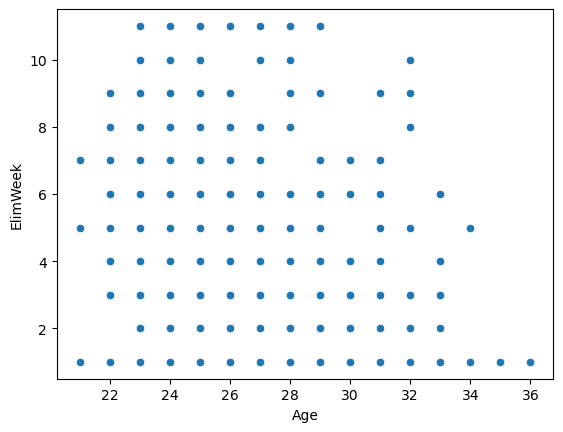

In [32]:
sns.scatterplot(data=merged_df, x="Age", y="ElimWeek")

In [33]:
def formPrediction(value : float) -> float:
    return (-0.07619969084779048 * value) + 5.478743867777977

In [34]:
predictions = []
for i in range(25, 33):
    predictions.append(formPrediction(i))
    
predictions

[3.5737515965832154,
 3.497551905735425,
 3.421352214887634,
 3.3451525240398436,
 3.268952833192053,
 3.1927531423442628,
 3.1165534514964723,
 3.040353760648682]

### 4. Final Answer

In the first cell seen below, state the name of your predicted winner. 
In the second cell seen below, justify your prediction using an evaluation technique like RMSE or percent accuracy.

#### State the name of your predicted winner here.

#### Justify your prediction here.

#### Attempts to fix accuracy

 - Changed the value of Winner. Was originally set to 0 which offset the graph a tad bit since the higher the week the better your score. Changed it to 10 and then after a bit of research set it to 6. This resulted in an accuracy of ~9%
 
 - Factored in a "quit" number so those who decided to quit the competition got moved to week 0 hopefully preventing them from impeding the data even more. This resulted in an accuracy of ~9%
 
 - Got 1000 rows of data which resulted in an accuracy of ~10%
 